# Transfer Learning

A common and highly effective approach for deep learning when we are working with small datasets is **transfer learning**. This technique consists on using a pretrained network that was previously trained on a large dataset, typically on a large-scale image-classification task. 

Let us star with our typical `google.colab` cell.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/TC3007C/CNN/Cats and Dogs"
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/TC3007C/CNN/Cats and Dogs
/content/drive/MyDrive/TC3007C/CNN/Cats and Dogs


We will import the same libraries we have been using before, but we will need an extra one called `VGG16`, which is precisely our pretrained model. More on this later.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16

We are going to use data augmentation plus transfer learning. But be careful, this is a very demanding task for a CPU, so it is better to turn to the computational power of GPUs, in case you can do that. The code for including data augmentation should be familiar, so you know the drill.

In [26]:
base_dir = 'cats_and_dogs_small'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size = (150, 150),
																										batch_size = 20,
																										class_mode ='binary')

validation_generator = validation_datagen.flow_from_directory(
																										validation_dir,
                                                    target_size = (150,150),
																										batch_size =20,
																										class_mode= 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


So, going back to transfer learning, it is viable to use this option if this original dataset is large enough and general enough. This means that the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer-vision problems, even though these new problems may involve completely different classes than those of the original task. 

In this case, the `VGG16` CNN, which was  developed by Karen Simonyan and Andrew Zisserman in 2014, was trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, so it is reasonable to expect a good performance on our *cats and dogs* dataset.

There are two ways to use a pretrained network: feature extraction and fine-tuning. We will focus on feature extraction for now.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As you probably know by now, CNNs, in general, are comprised of two parts: a series of pooling and convolution layers, and a densely connected classifier. The first part is called the **convolutional base** of the model. In the case of CNNs, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classsifer on top of the convolutional base.

It is worthwhile to point out that if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base. This is the case because deeper layers will be more specialized than shallow layers. 

And now we import the convolutional base of the VGG16 architecture and let us take a peek.

In [27]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Almost 15 million parameters! That's a lot! Anyhoo, let us proceed despite that. Now we need to add the fully connected neural network on top of the convolutional base. This can be done easily with `Keras`.

In [28]:
model = models.Sequential([
                           conv_base,
                           Flatten(),
                           Dense(256, activation='relu'),
                           Dense(1, activation='sigmoid')                    
                          ])

And just out of curiosity, how many parameters will our model have in total? Close to 17 million...that was untrainable back in the day! But not now.

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Before compiling and trainig the model, it is **very important** to "freeze" the weights of the convolutional base: we do not want to modify the features that the pretrained network learned with the large dataset it was trained on, thus tranfer learning, but we do want to modify the randomly initialized parameters of the "dense" network during training. That said, we need to tell `Keras` that *this is the way* we want things to be done around. 

In [30]:
conv_base.trainable = False
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.RMSprop(learning_rate=2e-5), metrics=['acc'])

And now we train.

In [31]:
history = model.fit(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 29s 267ms/step - loss: 0.5982 - acc: 0.6840 - val_loss: 0.4530 - val_acc: 0.8230
Epoch 2/30
100/100 [==============================] - 23s 228ms/step - loss: 0.4847 - acc: 0.7860 - val_loss: 0.3699 - val_acc: 0.8680
Epoch 3/30
100/100 [==============================] - 23s 231ms/step - loss: 0.4337 - acc: 0.8065 - val_loss: 0.3348 - val_acc: 0.8580
Epoch 4/30
100/100 [==============================] - 23s 232ms/step - loss: 0.4127 - acc: 0.8245 - val_loss: 0.3111 - val_acc: 0.8830
Epoch 5/30
100/100 [==============================] - 22s 218ms/step - loss: 0.3998 - acc: 0.8195 - val_loss: 0.2937 - val_acc: 0.8860
Epoch 6/30
100/100 [==============================] - 22s 220ms/step - loss: 0.3723 - acc: 0.8360 - val_loss: 0.2819 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 22s 219ms/step - loss: 0.3630 - acc: 0.8335 - val_loss: 0.2747 - val_acc: 0.8950
Epoch 8/30
100/100 [==============================] - 2

As you can observe, no overfitting and a sweet 90% plus percent accuracy on the validation set. Pretty good. Let us visualize those results.

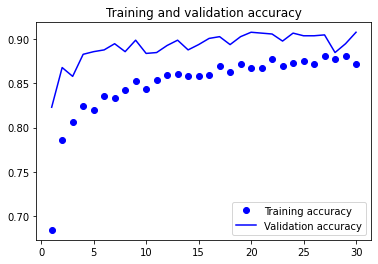

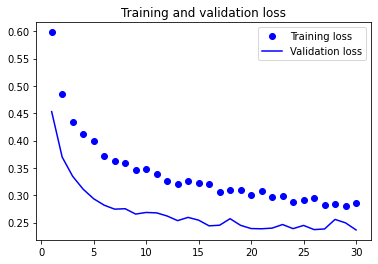

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Reference

[1] Chollet, Francois. *Deep learning with Python*. Simon and Schuster, 2021.